In [2]:
# import library
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [3]:
# load data
edstay = pd.read_csv('./data/edstays.csv.gz', compression = 'gzip')
diagnosis = pd.read_csv('./data/diagnosis.csv.gz', compression = 'gzip')
med = pd.read_csv('./data/medrecon.csv.gz', compression = 'gzip')
pyxis = pd.read_csv('./data/pyxis.csv.gz', compression = 'gzip')
triage = pd.read_csv('./data/triage.csv.gz', compression = 'gzip')
vital = pd.read_csv('./data/vitalsign.csv.gz', compression = 'gzip')

In [129]:
# process edstay df
# drop useless columns
edstay_1 = edstay.loc[:, ['subject_id', 'stay_id', 'disposition', 'intime', 'outtime', 'gender', 'race']]

# keep home & admitted only
edstay_2 = edstay_1[(edstay_1['disposition'] == 'HOME')| (edstay_1['disposition'] == 'ADMITTED')]

# calculate ed stay time
edstay_2.intime = pd.to_datetime(edstay_2.intime, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
edstay_2.outtime = pd.to_datetime(edstay_2.outtime, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
edstay_2['staytime'] = round((edstay_2['outtime'] - edstay_2['intime']).dt.total_seconds() / (24 * 60), 2)

edstay_2['label'] = edstay_2['disposition'] == 'ADMITTED'
edstay_2['label'] = edstay_2['label'].astype(int)

# create df for joining
edstay_df = edstay_2.drop(columns = ['intime', 'outtime', 'disposition'])
edstay_df = edstay_df.rename(columns = {'label' : 'disposition'})
edstay_df = edstay_df.fillna('')
edstay_df.head()

,subject_id,stay_id,gender,race,staytime,disposition
0,10000032,33258284,F,WHITE,10.54,1
1,10000032,38112554,F,WHITE,14.04,1
2,10000032,35968195,F,WHITE,11.92,1
3,10000032,32952584,F,WHITE,33.75,0
4,10000032,39399961,F,WHITE,20.25,1


In [130]:
# process diagnosis, med, pyxis
# drop useless columns
diagnosis_1 = diagnosis.loc[:, ['stay_id', 'icd_title']]
med_1 = med.loc[:, ['stay_id', 'name']]
pyxis_1 = pyxis.loc[:, ['stay_id', 'name']]

med_1 = med_1.rename(columns = {'name' : 'current_med'})
pyxis_1 = pyxis_1.rename(columns = {'name' : 'prescription'})

In [134]:
# put all icd title into 1 string for each id
diagnosis_1.icd_title = diagnosis_1.icd_title.str.lower()
diagnosis_1 = diagnosis_1.fillna('')
diagnosis_df = diagnosis_1.groupby('stay_id')['icd_title'].apply(lambda x: list(set(x))).reset_index()
diagnosis_df['icd_title'] = diagnosis_df['icd_title'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

In [136]:
# put all current medication into 1 string for each id
med_1.current_med = med_1.current_med.str.lower()
med_1 = med_1.fillna('')
med_df = med_1.groupby('stay_id')['current_med'].apply(lambda x: list(set(x))).reset_index()
med_df['current_med'] = med_df['current_med'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

In [137]:
# put all prescription into 1 string for each id
pyxis_1.prescription = pyxis_1.prescription.str.lower()
pyxis_1 = pyxis_1.fillna('')
pyxis_df = pyxis_1.groupby('stay_id')['prescription'].apply(lambda x: list(set(x))).reset_index()
pyxis_df['prescription'] = pyxis_df['prescription'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

In [6]:
# process vital
# find most extreme value for each vital per individual
vital_1 = vital.drop(columns = ['charttime', 'rhythm', 'pain'])
vital_1

,subject_id,stay_id,temperature,heartrate,resprate,o2sat,sbp,dbp
0,10000032,32952584,NaN,83.0,24.0,97.0,90.0,51.0
1,10000032,32952584,NaN,85.0,22.0,98.0,76.0,39.0
2,10000032,32952584,NaN,84.0,22.0,97.0,75.0,39.0
3,10000032,32952584,NaN,84.0,20.0,99.0,86.0,51.0
4,10000032,32952584,98.4,86.0,20.0,98.0,65.0,37.0
...,...,...,...,...,...,...,...,...
1564605,19999828,32917002,98.1,109.0,15.0,96.0,111.0,78.0
1564606,19999914,32002659,99.5,81.0,10.0,100.0,93.0,55.0
1564607,19999987,34731548,NaN,112.0,18.0,NaN,118.0,83.0
1564608,19999987,34731548,NaN,111.0,18.0,NaN,123.0,82.0


In [138]:
# maximum vitals
max = vital_1.groupby(by = 'stay_id').max()
max = max.drop(columns = 'subject_id')
max = max.add_prefix('max_')

In [139]:
# minimum vitals
min = vital_1.groupby(by = 'stay_id').min()
min = min.drop(columns = 'subject_id')
min = min.add_prefix('min_')

In [140]:
# merge max and min vitals
vital_2 = pd.merge(max, min, on = ['stay_id'], how = 'outer')
vital_2.shape

(408146, 12)

In [141]:
# get all rhythm for each id & merge
rhythm = vital.loc[:, ['stay_id', 'rhythm']].dropna(subset = ['rhythm'])
rhythm_1 = rhythm.groupby(by = 'stay_id')['rhythm'].apply(lambda x: list(set(x.str.lower()))).reset_index()
rhythm_1['rhythm'] = rhythm_1['rhythm'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
vital_3 = pd.merge(vital_2, rhythm_1, on = ['stay_id'], how = 'left')

In [142]:
# get all pain for each id & merge
pain = vital.loc[:, ['stay_id', 'pain']].dropna(subset = ['pain'])
pain_1 = pain.groupby(by = 'stay_id')['pain'].apply(lambda x: list(set(x.str.lower()))).reset_index()
pain_1['pain'] = pain_1['pain'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
vital_df = pd.merge(vital_3, pain_1, on = ['stay_id'], how = 'left')

In [144]:
vital_df = vital_df.fillna('')
vital_df

,stay_id,max_temperature,max_heartrate,max_resprate,max_o2sat,max_sbp,max_dbp,min_temperature,min_heartrate,min_resprate,min_o2sat,min_sbp,min_dbp,rhythm,pain
0,30000012,98.8,96.0,18.0,100.0,160.0,54.0,98.6,80.0,13.0,93.0,112.0,44.0,,0
1,30000017,97.7,70.0,20.0,97.0,142.0,90.0,97.7,70.0,20.0,97.0,142.0,90.0,,0
2,30000038,99.6,80.0,20.0,96.0,144.0,73.0,97.1,54.0,18.0,95.0,141.0,59.0,,"0, 5"
3,30000039,98.1,99.0,22.0,98.0,194.0,112.0,97.4,80.0,16.0,95.0,147.0,75.0,,0
4,30000094,98.1,79.0,20.0,99.0,129.0,95.0,97.9,60.0,18.0,94.0,101.0,69.0,,"0, 2"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408141,39999933,98.4,59.0,16.0,100.0,108.0,66.0,98.4,59.0,16.0,100.0,108.0,66.0,,
408142,39999939,98.3,80.0,19.0,100.0,133.0,87.0,98.1,65.0,15.0,94.0,116.0,73.0,sr,0
408143,39999953,98.3,81.0,16.0,100.0,124.0,86.0,98.3,81.0,16.0,100.0,124.0,86.0,,0
408144,39999961,99.3,119.0,22.0,100.0,139.0,90.0,98.0,86.0,16.0,98.0,114.0,69.0,,"5, 7, 8, 10"


In [145]:
# change triage column names
triage_df = triage.add_prefix('triage_')
triage_df = triage_df.rename(columns = {'triage_subject_id' : 'subject_id',
                                        'triage_stay_id' : 'stay_id',
                                        'triage_acuity' : 'acuity',
                                        'triage_chiefcomplaint' : 'chiefcomplaint'})
triage_df = triage_df.drop(columns = 'subject_id')
triage_df = triage_df.fillna('')

In [146]:
# join all tables together
df_1 = pd.merge(edstay_df, diagnosis_df, on = 'stay_id', how = 'left')
df_2 = pd.merge(df_1, med_df, on = 'stay_id', how = 'left')
df_3 = pd.merge(df_2, pyxis_df, on = 'stay_id', how = 'left')
df_4 = pd.merge(df_3, triage_df, on = 'stay_id', how = 'left')
all_df = pd.merge(df_4, vital_df, on = 'stay_id', how = 'left')
all_df.head()

,subject_id,stay_id,gender,race,staytime,disposition,icd_title,current_med,prescription,triage_temperature,...,max_sbp,max_dbp,min_temperature,min_heartrate,min_resprate,min_o2sat,min_sbp,min_dbp,rhythm,pain
0,10000032,33258284,F,WHITE,10.54,1,"asymptomatic hiv infection, oth sequela, chr l...","nicotine, ergocalciferol (vitamin d2), raltegr...",NaN,98.4,...,107.0,60.0,97.7,79.0,16.0,98.0,107.0,60.0,,0
1,10000032,38112554,F,WHITE,14.04,1,"cirrhosis of liver nos, asymptomatic hiv infec...","calcium carbonate, nicotine, raltegravir [isen...","ondansetron, morphine",98.9,...,96.0,64.0,97.9,76.0,17.0,93.0,95.0,57.0,,5
2,10000032,35968195,F,WHITE,11.92,1,"cirrhosis of liver nos, asymptomatic hiv infec...","nicotine, raltegravir [isentress], lactulose, ...","ondansetron, donnatol (elixir), aluminum-magne...",99.4,...,102.0,60.0,98.1,91.0,17.0,99.0,98.0,58.0,,
3,10000032,32952584,F,WHITE,33.75,0,unspecified viral hepatitis c without hepatic ...,"calcium carbonate, nicotine, raltegravir [isen...",albuterol inhaler,97.8,...,90.0,51.0,98.2,83.0,16.0,97.0,65.0,37.0,,0
4,10000032,39399961,F,WHITE,20.25,1,"altered mental status , encephalopathy, unspec...","calcium carbonate, nicotine, raltegravir [isen...","dextrose 50%, calcium gluconate, ceftriaxone (...",98.7,...,93.0,57.0,98.1,78.0,14.0,92.0,73.0,40.0,,"asleep, u, uta, unable"


In [147]:
column_name = {'staytime' : 'emergency department stay time in hours',
               'icd_title' : 'diagnosis icd title',
               'current_med' : 'current medication',
               'triage_temperature' : 'temperature at triage',
               'triage_heartrate' : 'heartrate at triage',
               'triage_resprate' : 'respiratory rate at triage',
               'triage_o2sat' : 'oxygen saturation at triage',
               'triage_sbp' : 'sbp at triage',
               'triage_dbp' : 'dbp at triage', 
               'triage_pain' : 'pain level at triage',
               'max_temperature' : 'maximum temperature',
               'max_heartrate' : 'maximum heartrate',
               'max_resprate' : 'maximum respiratory rate', 
               'max_o2sat' : 'maximum oxygen saturation', 
               'max_sbp' : 'maximum sbp',
               'max_dbp' : 'maximum dbp',
               'min_temperature' : 'minimum temperature',
               'min_heartrate' : 'minimum heartrate',
               'min_resprate' : 'minimum respiratory rate', 
               'min_o2sat' : 'minimum oxygen saturation', 
               'min_sbp' : 'minimum sbp',
               'min_dbp' : 'minimum dbp',
               'rhythm' : 'heart rhythm'}
all_df = all_df.rename(columns = column_name)

In [74]:
#def list_to_string(df, col_name):
#    df[col_name] = df[col_name].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
#    return df

In [75]:
#columns_to_str = ['diagnosis icd title', 'current medication', 'prescription', 'heart rhythm', 'pain']
#for col in columns_to_str:
#    list_to_string(all_df, col)

In [167]:
all_df.to_csv('processed_data.csv.gz', compression = 'gzip')

In [150]:
acuity_dict = {1.0 : 'esi 1, triage process stops, patient taken directly to a room and imeediate physician intervention requrested',
               2.0 : 'esi 2, triage nurse notifies resource nurse and appropriate placement tbd',
               3.0 : 'esi 3, patient requires two or more resources',
               4.0 : 'esi 4, patient requires one resource',
               5.0 : 'esi 5, patient not requires any resource'}
all_df_1 = all_df.replace({'acuity' : acuity_dict})

In [152]:
def generate_text_df(df):
    col_name = list(df.columns)
    out_df = pd.DataFrame()
    
    for i in range(len(col_name)):
        if col_name[i] == 'stay_id' or col_name[i] == 'disposition':
            out_df[col_name[i]] = df[col_name[i]]
        else:
            out_df[col_name[i]] = col_name[i] + ' : ' + df[col_name[i]].astype(str)
    
    return out_df

In [159]:
text_df = generate_text_df(all_df_1)

In [160]:
text_df = text_df.fillna('')

In [161]:
clinical_text = text_df.drop(columns = ['stay_id', 'subject_id', 'disposition']).apply(lambda row: '. '.join([str(x) for x in row]), axis = 1)

In [162]:
clinical_text_df = text_df.loc[:, ['stay_id']]
clinical_text_df['text'] = clinical_text.str.lower()
clinical_text_df['disposition'] = text_df['disposition']

In [168]:
clinical_text_df.to_csv('clinical_text.csv.gz', compression = 'gzip')

(array([3.94273e+05, 1.27470e+04, 9.56000e+02, 1.21000e+02, 2.90000e+01,
        6.00000e+00, 1.00000e+01, 2.00000e+00, 0.00000e+00, 2.00000e+00]),
 array([  1. ,  11.8,  22.6,  33.4,  44.2,  55. ,  65.8,  76.6,  87.4,
         98.2, 109. ]),
 <BarContainer object of 10 artists>)

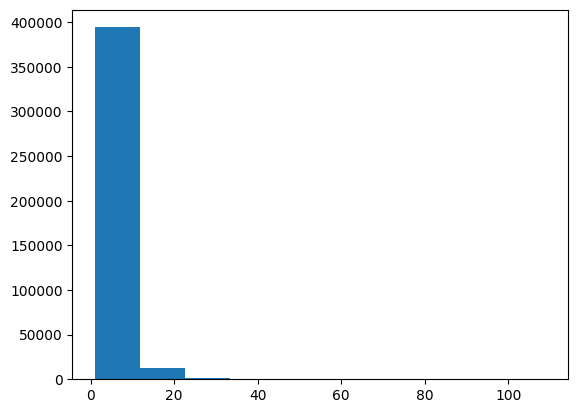

In [109]:
temp = vital.groupby('stay_id').count()['charttime']
import matplotlib.pyplot as plt
plt.hist(temp)

(array([74999., 99815., 74315., 47944., 31755., 21597., 15101., 10788.,
         7931.,  5796.,  4232.,  3328.,     0.,  2378.,  1826.,  1367.,
         1025.,   806.,   599.,   494.,   381.,   301.,   242.,   202.,
          132.]),
 array([ 1.  ,  1.92,  2.84,  3.76,  4.68,  5.6 ,  6.52,  7.44,  8.36,
         9.28, 10.2 , 11.12, 12.04, 12.96, 13.88, 14.8 , 15.72, 16.64,
        17.56, 18.48, 19.4 , 20.32, 21.24, 22.16, 23.08, 24.  ]),
 <BarContainer object of 25 artists>)

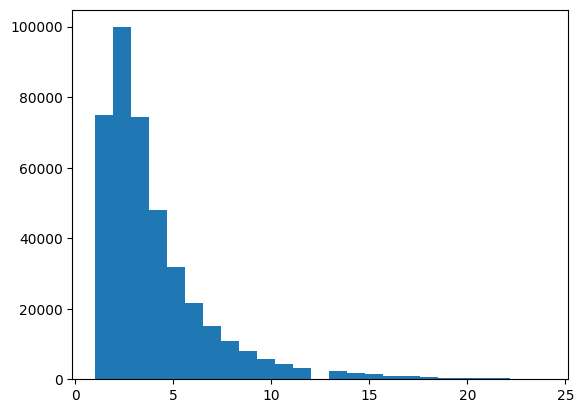

In [117]:
temp_1 = temp.to_frame()
temp_1 = temp_1[temp_1['charttime'] < 25]
plt.hist(temp_1['charttime'], bins = 25)